<a href="https://colab.research.google.com/github/Thush099/CM2604-Churn-Classifier/blob/main/CM2604_Telco_Churn_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telco Customer Churn — Notebook
Author: Thushanth Mahendran
Course: CM2604 Machine Learning


Load libraries and set plotting style.

In [4]:
# 1. IMPORTS & SETTINGS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io, os
from google.colab import files

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, roc_curve, auc
)
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import joblib
import warnings
warnings.filterwarnings("ignore")
sns.set(rc={"figure.figsize": (8,5)})

print("Libraries loaded. TensorFlow version:", tf.__version__)

Libraries loaded. TensorFlow version: 2.19.0


upload dataset

In [5]:
# 2. LOAD CSV FROM COLAB FILE DIRECTORY

import pandas as pd

csv_path = "/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(csv_path)

print("Dataset loaded from:", csv_path)
print("Shape (rows, columns):", df.shape)

print("\nFirst three rows:")
display(df.head(3))

print("\nColumn dtypes summary:")
print(df.dtypes.value_counts())

Dataset loaded from: /content/WA_Fn-UseC_-Telco-Customer-Churn.csv
Shape (rows, columns): (7043, 21)

First three rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes



Column dtypes summary:
object     18
int64       2
float64     1
Name: count, dtype: int64


### Inspect dataset structure
Check columns, datatypes and missing values so we know what cleaning is needed.

In [6]:
# 3 - inspect columns/dtypes/missing
print("Shape (rows, cols):", df.shape)
print("\nColumns list:")
print(df.columns.tolist())

print("\nDtypes summary:")
print(df.dtypes)

print("\nMissing values (sorted):")
print(df.isna().sum().sort_values(ascending=False).head(20))

Shape (rows, cols): (7043, 21)

Columns list:
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Dtypes summary:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing va

### Quick sanity checks
Look for duplicates and unusual values in ID or TotalCharges.

In [7]:
# 4 - sanity checks
# If customerID exists, check duplicates
if 'customerID' in df.columns:
    print("customerID duplicates:", df['customerID'].duplicated().sum())

# Check a few samples from TotalCharges to see formatting
if 'TotalCharges' in df.columns:
    print("\nTotalCharges sample values:")
    print(df['TotalCharges'].sample(8).values)

customerID duplicates: 0

TotalCharges sample values:
['1505.05' '2535.55' '1004.5' '7711.45' '3309.25' '706.6' '2540.1'
 '2209.75']


### Cleaning: convert TotalCharges to numeric and remove identifier
Convert TotalCharges to numeric (coerce invalid → NaN) and drop very few NaN rows.
Also drop customerID (identifier).

In [8]:
# 5 - clean TotalCharges and drop ID
if 'TotalCharges' in df.columns and df['TotalCharges'].dtype == 'object':
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    print("TotalCharges NaNs after coercion:", df['TotalCharges'].isna().sum())

# If only a tiny fraction missing, drop them and report
if 'TotalCharges' in df.columns:
    n_missing = df['TotalCharges'].isna().sum()
    if n_missing > 0 and n_missing / len(df) < 0.01:
        df = df.dropna(subset=['TotalCharges']).reset_index(drop=True)
        print("Dropped rows with missing TotalCharges. New shape:", df.shape)
    elif n_missing > 0:
        print("Warning: several TotalCharges missing; consider imputation instead of dropping.")

# Drop ID column if present
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])
    print("Dropped customerID column. Shape now:", df.shape)


TotalCharges NaNs after coercion: 11
Dropped rows with missing TotalCharges. New shape: (7032, 21)
Dropped customerID column. Shape now: (7032, 20)


### Encode target and identify feature types
Encode Churn to 0/1 and show which columns are numeric and which are categorical.

In [9]:
# 6 - target encoding and feature lists
if 'Churn' not in df.columns:
    raise ValueError("No 'Churn' column found — check dataset.")
df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})

# Detect numeric and categorical
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
if 'Churn' in numeric_cols:
    numeric_cols.remove('Churn')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns (count):", len(numeric_cols))
print(numeric_cols)
print("\nCategorical columns (count):", len(categorical_cols))
print(categorical_cols)
print("\nChurn distribution (proportion):")
print(df['Churn'].value_counts(normalize=True).round(3))

Numeric columns (count): 4
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Categorical columns (count): 15
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Churn distribution (proportion):
Churn
0    0.734
1    0.266
Name: proportion, dtype: float64


### EDA: class balance and some feature relationships
Plot churn counts and a couple of numeric feature comparisons.

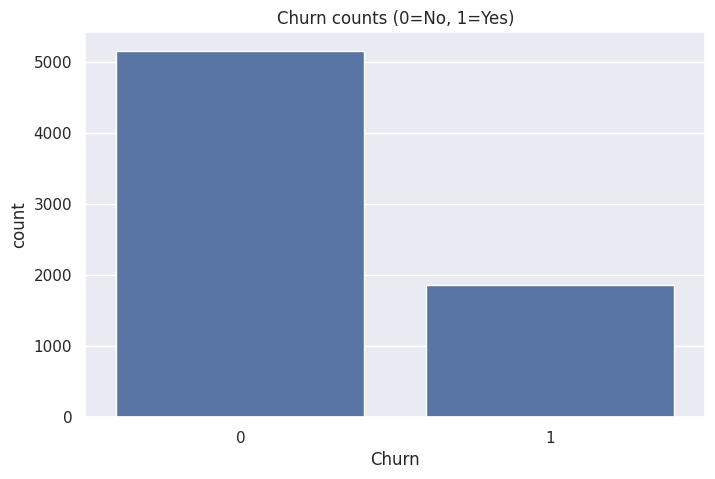

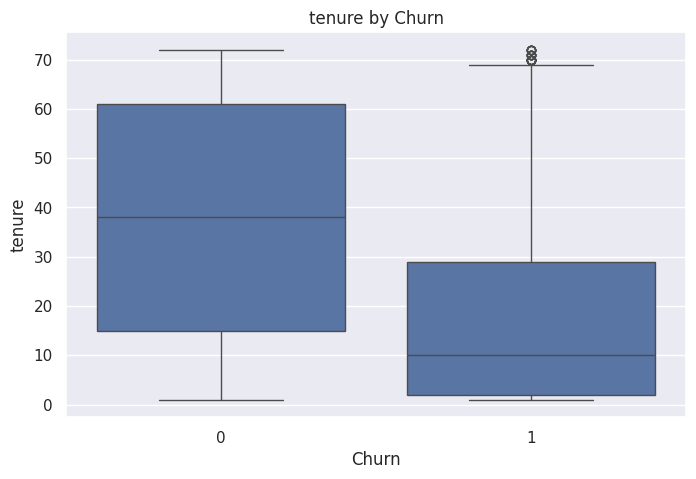

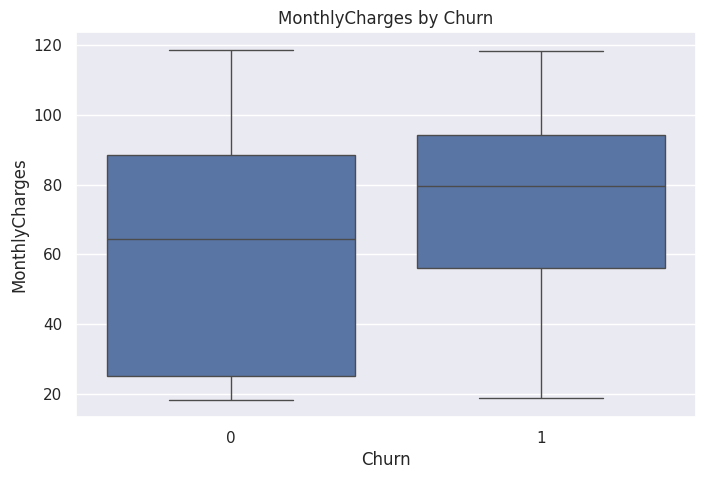

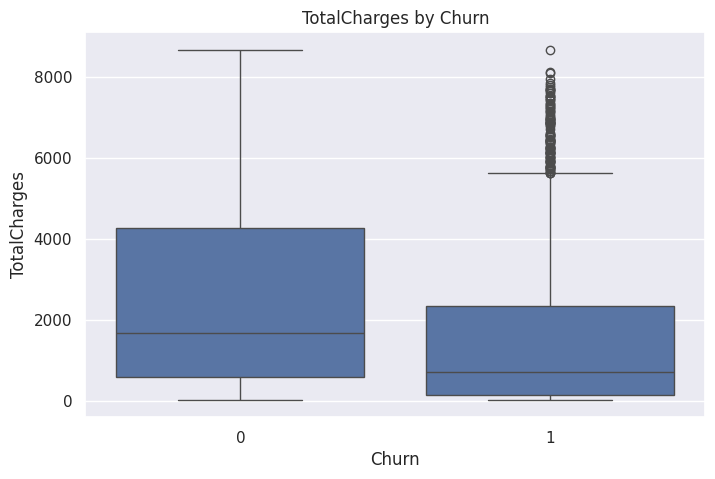

In [10]:
# CELL 7 - EDA plots (run one by one if needed)
import matplotlib.pyplot as plt
import seaborn as sns

# Churn counts
plt.figure()
sns.countplot(data=df, x='Churn')
plt.title('Churn counts (0=No, 1=Yes)')
plt.show()

# Tenure, MonthlyCharges, TotalCharges if present
for col in ['tenure','MonthlyCharges','TotalCharges']:
    if col in df.columns:
        plt.figure()
        sns.boxplot(data=df, x='Churn', y=col)
        plt.title(f'{col} by Churn')
        plt.show()